In [63]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
#!pip install torchsummary
#from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from statistics import mean

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

In [64]:
# Use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


### 1: Load data

torch.Size([32, 3, 96, 128])

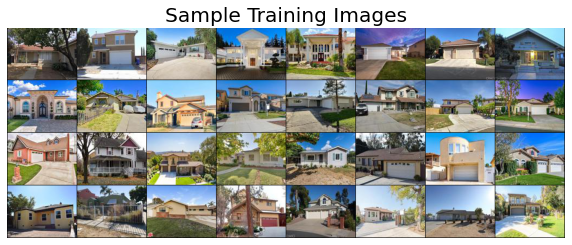

In [65]:
IMAGE_SIZE = (96, 128)
BATCH_SIZE = 32

data_dir = "../input/resized"

# transformer setup
transformer = transforms.Compose([
#     transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = datasets.ImageFolder(root=data_dir, transform=transformer)
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=False
                                          )

sample_batch = next(iter(data_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

# to confirm the shape of input data
next(iter(data_loader))[0].shape

### 2: Create the Generator

In [66]:
# def bede(n, stride, padding, dilation, filters):
#     return (n - 1) * stride - 2 * padding + dilation * (filters - 1) + 1


# a = bede(n=64, stride=2, padding=1, dilation=1, filters=4)
# a

In [67]:
class Generator(nn.Module):
    
    def __init__(self, LATENT_SIZE):
        super().__init__()
        
        self.main = nn.Sequential(
            
            # input dim: [-1, LATENT_SIZE, 1, 1]
            
            nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=(3, 4), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
                    
            # output dim: [-1, 512, 3, 4]

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            
            # output dim: [-1, 256, 6, 8]

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            
            # output dim: [-1, 128, 12, 16]

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout(0.3),
            
            # output dim: [-1, 64, 24, 32]
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            
            # output dim: [-1, 32, 48, 64]
         
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.1, inplace=True),
            
            # output dim: [-1, 3, 96, 128]
            
#             nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(3),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             # output dim: [-1, 3, 233, 311]
            
            nn.Tanh()
            
            # output dim: [-1, 3, 233, 311]
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [68]:
# g= G(96)
# summary(g, (96, 1, 1))

### 3: Create the Discriminator

In [69]:
# discriminator = models.resnet18(pretrained=True)
# # list(discriminator.named_children())

In [70]:
# last_layer = nn.Sequential(
#         nn.Linear(512, 1),
# #         nn.Flatten(),
#         nn.Sigmoid()
#         )
# discriminator.fc = last_layer
# #summary(discriminator, (3, 233, 311))

In [71]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
        
#             # input dim: [-1, 3, 192, 256]
            
#             nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.4, inplace=True),

            # output dim: [-1, 64, 96, 128]
#             nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),  # Turn this line and above on if wanted higher resolution, then turn next life off
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),  # Turning bias off for Conv2d as batchnorm has a built-in bias
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.3),

            # output dim: [-1, 64, 48, 64]

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.3),

            # output dim: [-1, 128, 24, 32]

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.3),

            # output dim: [-1, 256, 12, 16]

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.3),

            # output dim: [-1, 512, 6, 8]

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.3),
            
            # output dim: [-1, 1, 3, 5]

            nn.Flatten(),
            
            # output dim: [-1, 15]
            
            nn.Linear(15, 1),
            
            # output dim: [-1]

            nn.Sigmoid()
            
            # output dim: [-1]
        )

    def forward(self, input):
        output = self.main(input)
        return output

### 4: Initialize Weights

GANs can be quite sensitive to the initial weights assigned to each layer when we instantiate the model. We instantiate the generator and discriminator and then specify their initial weights as follows:
- `Conv2d()` layers: normal distribution with `mean=0.0` and `std=0.02`
- `ConvTranspose2d()` layers: normal distribution with `mean=0.0` and `std=0.02`
- `BatchNorm2d()` layers: normal distribution with `mean=1.0` and `std=0.02` for the weights, zeroes for the biases

In [72]:
# initiate generator (discriminator already initiated)
LATENT_SIZE = 96
generator = Generator(LATENT_SIZE)
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# summary(generator, (96, 1, 1))

In [73]:
# summary(discriminator, (3, 192, 256))

In [74]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator.apply(weights_init)
discriminator.apply(weights_init);

### 5: Train your GAN

I have used [tips and tricks for training GANs](https://github.com/soumith/ganhacks) to finetune the GAN model.

In [75]:
img_list = []
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1).to(device)

In [76]:
def trainer(data_loader, generator, discriminator, criterion, optimizerG, optimizerD, epochs=10):
    img_list = []  # To track image change
    fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1).to(device)
    
    print('Training started:\n')

    D_real_epoch, D_fake_epoch, loss_dis_epoch, loss_gen_epoch = [], [], [], []

    for epoch in range(epochs):

        D_real_iter, D_fake_iter, loss_dis_iter, loss_gen_iter = [], [], [], []

        for real_batch, _ in data_loader:

            # STEP 1: train discriminator
            # ==================================
            # Train with real data
            discriminator.zero_grad()

            real_batch = real_batch.to(device)
            real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float).to(device)

            output = discriminator(real_batch).view(-1)
            loss_real = criterion(output, real_labels)

            # Iteration book-keeping
            D_real_iter.append(output.mean().item())

            # Train with fake data
            noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1).to(device)

            fake_batch = generator(noise)
            fake_labels = torch.zeros_like(real_labels)

            output = discriminator(fake_batch.detach()).view(-1)
            loss_fake = criterion(output, fake_labels)

            # Update discriminator weights
            loss_dis = loss_real + loss_fake
            loss_dis.backward()
            optimizerD.step()

            # Iteration book-keeping
            loss_dis_iter.append(loss_dis.mean().item())
            D_fake_iter.append(output.mean().item())

                    # STEP 2: train generator
            # ==================================
            generator.zero_grad()
            output = discriminator(fake_batch).view(-1)
            loss_gen = criterion(output, real_labels)
            loss_gen.backward()

            # Book-keeping
            loss_gen_iter.append(loss_gen.mean().item())

            # Update generator weights and store loss
            optimizerG.step()

        print(f"Epoch ({epoch + 1}/{epochs})\t",
              f"Loss_G: {mean(loss_gen_iter):.4f}",
              f"Loss_D: {mean(loss_dis_iter):.4f}\t",
              f"D_real: {mean(D_real_iter):.4f}",
              f"D_fake: {mean(D_fake_iter):.4f}")

        # Epoch book-keeping
        loss_gen_epoch.append(mean(loss_gen_iter))
        loss_dis_epoch.append(mean(loss_dis_iter))
        D_real_epoch.append(mean(D_real_iter))
        D_fake_epoch.append(mean(D_fake_iter))

        # Keeping track of the evolution of a fixed noise latent vector
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake_images, normalize=True, nrows=10))

    print("\nTraining ended.")
    return D_real_epoch, D_fake_epoch, loss_dis_epoch, loss_gen_epoch, img_list

In [77]:
D_real_epoch, D_fake_epoch, loss_dis_epoch, loss_gen_epoch, img_list = trainer(data_loader, generator, discriminator, criterion, optimizerG, optimizerD, epochs=50)

Training started:

Epoch (1/50)	 Loss_G: 1.6605 Loss_D: 0.6704	 D_real: 0.6852 D_fake: 0.2314
Epoch (2/50)	 Loss_G: 2.1767 Loss_D: 0.3546	 D_real: 0.8330 D_fake: 0.1463
Epoch (3/50)	 Loss_G: 2.6207 Loss_D: 0.2397	 D_real: 0.8913 D_fake: 0.1071


KeyboardInterrupt: 

In [ ]:
# Save model
PATH = "./model.pt"

torch.save({
            "generator_state_dict": generator.state_dict(),
            "discriminator_state_dict": discriminator.state_dict(),
            "optimizerG_state_dict": optimizerG.state_dict(),
            "optimizerD_state_dict": optimizerD.state_dict(),
            "D_real_epoch": D_real_epoch, 
            "D_fake_epoch": D_fake_epoch, 
            "loss_dis_epoch": loss_dis_epoch, 
            "loss_gen_epoch": loss_gen_epoch
            }, PATH)

In [ ]:
IMAGE_SIZE = (96, 128)
BATCH_SIZE = 32  # change batch size for customized image counts

data_dir = "../input/resized"

# transformer setup
transformer = transforms.Compose([
#     transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = datasets.ImageFolder(root=data_dir, transform=transformer)
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=False
                                          )

sample_batch = next(iter(data_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

In [ ]:
PATH = "../input/model350/model350.pt"
LATENT_SIZE = 96

# Create instances of model
criterion = nn.BCELoss()
generator = Generator(LATENT_SIZE)
discriminator = Discriminator()


# Load model weights and losses
checkpoint = torch.load(PATH)
generator.load_state_dict(checkpoint["generator_state_dict"])
discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
D_real_epoch = checkpoint["D_real_epoch"]
D_fake_epoch = checkpoint["D_fake_epoch"] 
loss_dis_epoch = checkpoint["loss_dis_epoch"] 
loss_gen_epoch = checkpoint["loss_gen_epoch"]


# resume training of the parameters (see alternatives for evalulation)
generator.train()
discriminator.train()

# --or--
# generator.eval()
# discriminator.eval()

# sending the loaded models to cuda (the previous model has been trained on one)
# moving model to gpu needs to happen before constructing optimizer
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    
# Construct and load optimizer parameters
optimizerG = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
# optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
# optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])

# Train loaded model
D_real_epoch2, D_fake_epoch2, loss_dis_epoch2, loss_gen_epoch2, img_list = trainer(data_loader, generator, discriminator, criterion, optimizerG, optimizerD, epochs=50)

In [ ]:
# Save model
PATH = "./model8.pt"

torch.save({
            "generator_state_dict": generator.state_dict(),
            "discriminator_state_dict": discriminator.state_dict(),
            "optimizerG_state_dict": optimizerG.state_dict(),
            "optimizerD_state_dict": optimizerD.state_dict(),
            "D_real_epoch": D_real_epoch, 
            "D_fake_epoch": D_fake_epoch, 
            "loss_dis_epoch": loss_dis_epoch, 
            "loss_gen_epoch": loss_gen_epoch
            }, PATH)

In [ ]:
# combine the losses and epochs from two trainings
D_real_epoch += D_real_epoch2
D_fake_epoch += D_fake_epoch2
loss_dis_epoch += loss_dis_epoch2
loss_gen_epoch += loss_gen_epoch2

plt.plot(np.array(loss_gen_epoch), label='loss_gen')
plt.plot(np.array(loss_dis_epoch), label='loss_dis')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

In [ ]:
plt.plot(np.array(D_real_epoch), label='D_real')
plt.plot(np.array(D_fake_epoch), label='D_fake')
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.legend();

In [ ]:
%%capture

fig = plt.figure(figsize=(10, 10))
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[::1]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('GAN.gif', writer='imagemagick', fps=2)

In [ ]:
HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.